# 5) Write a program in python to make an Artificial Neural Network(ANN) to evaluate accuracy on a diabetes dataset.

In [60]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_curve

In [61]:
df = pd.read_csv('diabetes.csv')

In [62]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
699,4,118,70,0,0,44.5,0.904,26,0
308,0,128,68,19,180,30.5,1.391,25,1
113,4,76,62,0,0,34.0,0.391,25,0
383,1,90,62,18,59,25.1,1.268,25,0
694,2,90,60,0,0,23.5,0.191,25,0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [64]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [65]:
class_counts = df['Outcome'].value_counts()
print(class_counts)

Outcome
0    500
1    268
Name: count, dtype: int64


<Axes: >

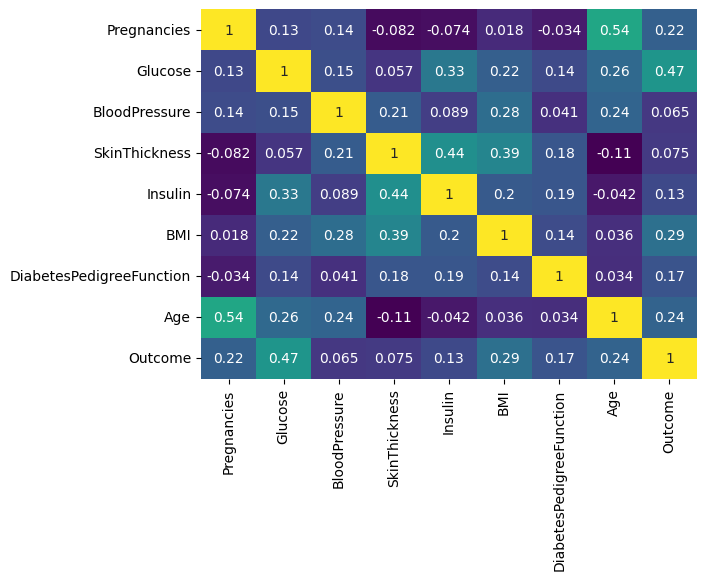

In [66]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='viridis')

In [67]:
x = df.iloc[:,0:8]
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [50]:
y = df.iloc[:,8]
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [51]:
# Feature scaling
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [52]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [53]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [54]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [55]:
# Define the model
model = Sequential()

# Input layer and first hidden layer with regularization and batch normalization
model.add(Dense(64, input_dim=8, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())

# Second hidden layer with Leaky ReLU activation and dropout
model.add(Dense(128, kernel_regularizer=l2(0.0005)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))  # Moderate dropout
model.add(BatchNormalization())

# Third hidden layer
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())

# Fourth hidden layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))  # Moderate dropout
model.add(BatchNormalization())

# Output layer
model.add(Dense(1, activation='sigmoid'))

C:\Users\Parth Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Parth Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [56]:
# Use Adam optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [57]:
# Train the model
model.fit(x_train_resampled, y_train_resampled, epochs=150, batch_size=32, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])

Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5407 - loss: 0.9960 - val_accuracy: 0.9193 - val_loss: 0.7542
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5848 - loss: 0.9108 - val_accuracy: 0.9565 - val_loss: 0.6900
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6204 - loss: 0.7943 - val_accuracy: 1.0000 - val_loss: 0.6478
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6562 - loss: 0.7676 - val_accuracy: 0.9938 - val_loss: 0.6247
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6745 - loss: 0.7632 - val_accuracy: 0.9938 - val_loss: 0.6022
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6874 - loss: 0.7848 - val_accuracy: 0.9814 - val_loss: 0.5864
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6461 - loss: 0.7485 - val_accuracy: 0.9441 - val_loss: 0.5700
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6845 - loss: 0.7526 - val_accuracy: 0.9255 - 

In [68]:
# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [69]:
# Print classification report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.81      0.58      0.67        99
           1       0.50      0.76      0.60        55

    accuracy                           0.64       154
   macro avg       0.66      0.67      0.64       154
weighted avg       0.70      0.64      0.65       154



In [70]:
# Find and apply the optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

y_pred_optimal = (y_pred > optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_optimal))

Optimal threshold: 0.7663078308105469
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154

